## LSTM Model

**Long Short-Term Memory (LSTM) models are highly advantageous for crypto price prediction due to their ability to capture long-term dependencies, handle sequential and irregularly sampled time series data, automatically extract relevant features, model complex market dynamics, and adapt to specific prediction tasks. By effectively capturing patterns over extended periods, handling irregular data intervals, and automatically learning from raw data, LSTMs excel in predicting cryptocurrency prices, making them a preferred choice for analyzing the volatile and complex nature of crypto markets.**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error

In [5]:
arb_data = yf.download('ARB11841-USD', start='2023-03-23', end='2024-03-15')
arb_data.dropna(inplace=True)
arb_data = arb_data[['Close']]

[*********************100%%**********************]  1 of 1 completed


In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(arb_data)


In [7]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

In [8]:
seq_length = 10
X, y = create_sequences(scaled_data, seq_length)
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

# Build LSTM model
model = Sequential([
    LSTM(50, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

Epoch 1/100
9/9 [==============================] - 3s 89ms/step - loss: 0.0242 - val_loss: 0.0537
Epoch 2/100
9/9 [==============================] - 0s 14ms/step - loss: 0.0082 - val_loss: 0.0122
Epoch 3/100
9/9 [==============================] - 0s 14ms/step - loss: 0.0063 - val_loss: 0.0340
Epoch 4/100
9/9 [==============================] - 0s 13ms/step - loss: 0.0058 - val_loss: 0.0240
Epoch 5/100
9/9 [==============================] - 0s 13ms/step - loss: 0.0050 - val_loss: 0.0090
Epoch 6/100
9/9 [==============================] - 0s 14ms/step - loss: 0.0048 - val_loss: 0.0091
Epoch 7/100
9/9 [==============================] - 0s 14ms/step - loss: 0.0044 - val_loss: 0.0079
Epoch 8/100
9/9 [==============================] - 0s 12ms/step - loss: 0.0041 - val_loss: 0.0091
Epoch 9/100
9/9 [==============================] - 0s 11ms/step - loss: 0.0045 - val_loss: 0.0079
Epoch 10/100
9/9 [==============================] - 0s 12ms/step - loss: 0.0041 - val_loss: 0.0105
Epoch 11/100
9/9 [=

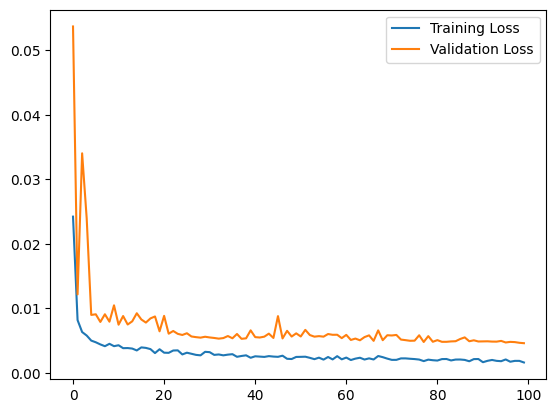

In [9]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


In [10]:
def forecast_future_values(model, X, num_days):
    forecast = []
    current_sequence = X[-seq_length:]
    for _ in range(num_days):
        next_value = model.predict(current_sequence.reshape(1, seq_length, 1))[0][0]
        forecast.append(next_value)
        current_sequence = np.append(current_sequence[1:], next_value)
    return forecast



In [11]:
future_forecast = forecast_future_values(model, X_val[-1], 6)
actual_prices = scaler.inverse_transform(y_val[-6:].reshape(-1, 1))
predicted_prices = scaler.inverse_transform(np.array(future_forecast).reshape(-1, 1))


1/1 [==============================] - 0s 40ms/step


In [12]:
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_train_pred_inv = scaler.inverse_transform(y_train_pred)
y_val_pred_inv = scaler.inverse_transform(y_val_pred)

3/3 [==============================] - 0s 5ms/step


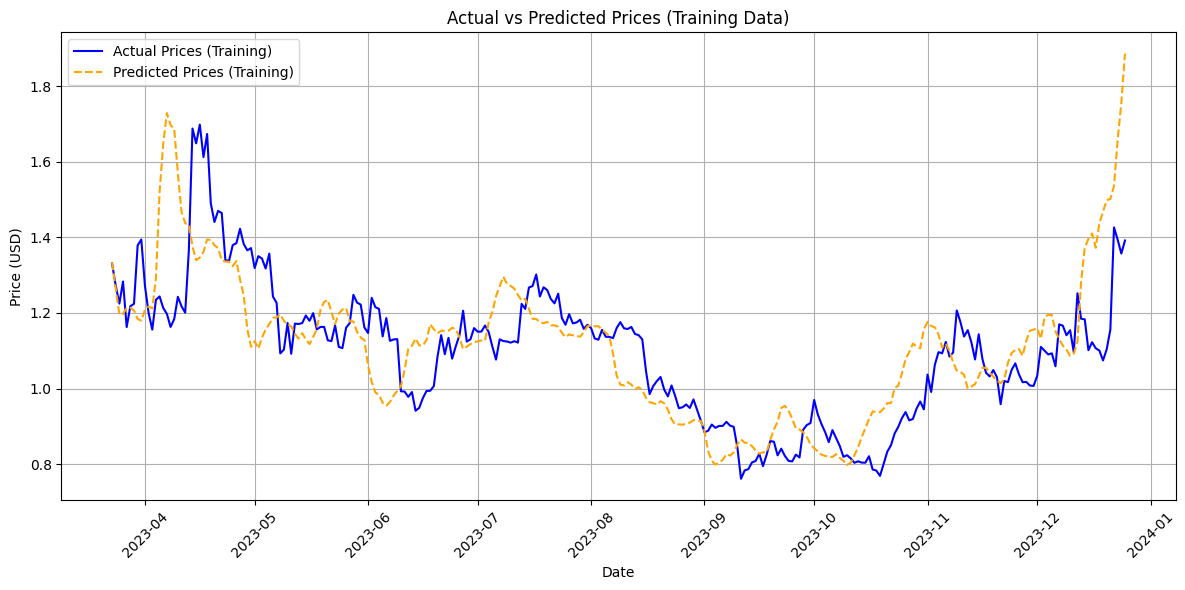

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(arb_data.index[:train_size], arb_data['Close'][:train_size], label='Actual Prices (Training)', color='blue')
plt.plot(arb_data.index[:train_size][-len(y_train_pred_inv):], y_train_pred_inv, label='Predicted Prices (Training)', linestyle='dashed', color='orange')
plt.title('Actual vs Predicted Prices (Training Data)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

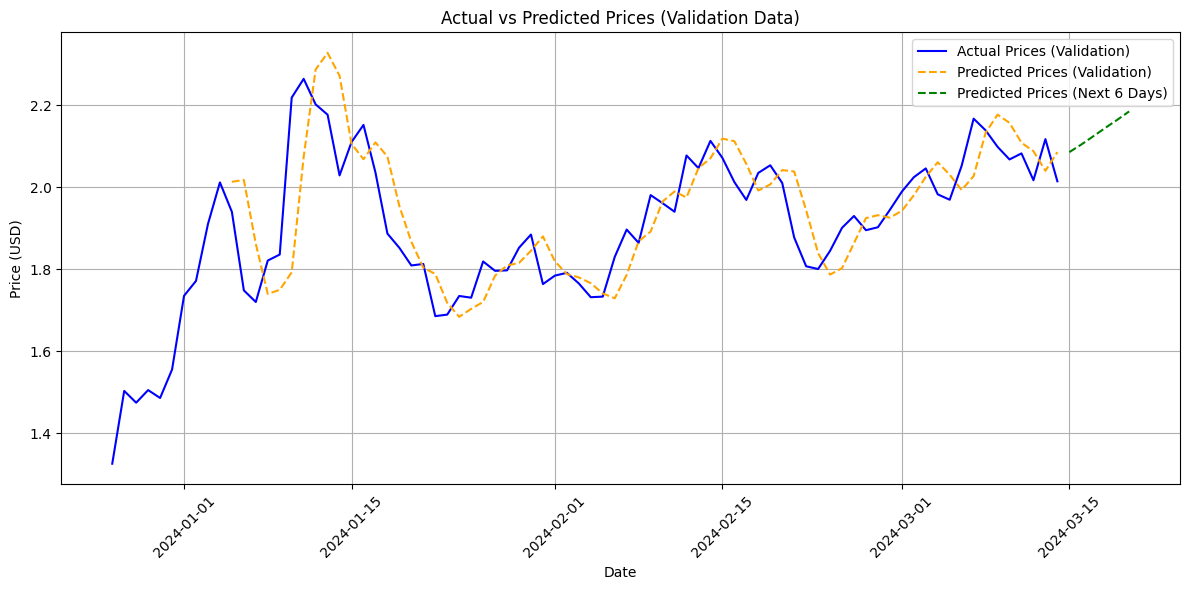

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(arb_data.index[train_size:], arb_data['Close'][train_size:], label='Actual Prices (Validation)', color='blue')
plt.plot(arb_data.index[train_size:][-len(y_val_pred_inv):], y_val_pred_inv, label='Predicted Prices (Validation)', linestyle='dashed', color='orange')
predicted_dates = pd.date_range(arb_data.index[-1] + pd.Timedelta(days=1), periods=6)
plt.plot(predicted_dates, predicted_prices, label='Predicted Prices (Next 6 Days)', linestyle='dashed', color='green')
plt.title('Actual vs Predicted Prices (Validation Data)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
last_date = arb_data.index[-1]
next_six_days = pd.date_range(last_date + pd.Timedelta(days=1), periods=6)
print("Predicted Prices for the Next 6 Days (from March 16, 2024):")
for i, (date, price) in enumerate(zip(next_six_days, predicted_prices), start=1):
    print(f"{date.strftime('%Y-%m-%d')}: {price[0]} USD")


Predicted Prices for the Next 6 Days (from March 16, 2024):
2024-03-15: 2.0860652923583984 USD
2024-03-16: 2.1046245098114014 USD
2024-03-17: 2.1247448921203613 USD
2024-03-18: 2.1451828479766846 USD
2024-03-19: 2.164914131164551 USD
2024-03-20: 2.185519218444824 USD


In [16]:
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
print("Root Mean Square Error (RMSE):", rmse)

Root Mean Square Error (RMSE): 0.09210762537976629
